In [9]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [10]:
num_points = 40
side_length = 10**3
N = 6  # Виленский

x_coords = np.random.uniform(0, side_length, num_points)
y_coords = np.random.uniform(0, side_length, num_points)

points = list(zip(x_coords, y_coords))

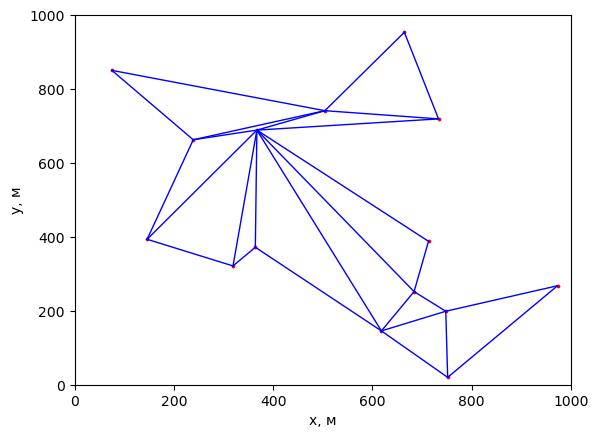

In [35]:
def is_point_upper_line(point, line):
    return (
        point[1] >=
        (point[0] - line[0][0]) / (line[1][0] - line[0][0])
        * (line[1][1] - line[0][1]) + line[0][1]
    )

def sqr_dist_from_point_to_point(point1, point2):
    return (point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2

def sqr_dist_from_point_to_line(point, line):
    (x0, y0), ((x1, y1), (x2, y2)) = point, sorted(line)

    line_dist = sqr_dist_from_point_to_point((x1, y1), (x2, y2))
    assert(line_dist != 0)

    x1 -= (x1 - x2) * abs(x1 - x2) / line_dist
    y1 -= (y1 - y2) * abs(y1 - y2) / line_dist
    x2 -= (x2 - x1) * abs(x2 - x1) / line_dist
    y2 -= (y2 - y1) * abs(y2 - y1) / line_dist

    projection = (
        (y2 - y1) * ((y0 - y1) * (x2 - x1) - (x0 - x1) * (y2 - y1)) / line_dist + x0,
        (x2 - x1) * ((x0 - x1) * (y2 - y1) - (y0 - y1) * (x2 - x1)) / line_dist + y0
    )

    if projection[0] > x2:
        return sqr_dist_from_point_to_point((x0, y0), (x2, y2))
    if projection[0] < x1:
        return sqr_dist_from_point_to_point((x0, y0), (x1, y1))
    return sqr_dist_from_point_to_point((x0, y0), projection)


first_edge = tuple(sorted((points[0], min(
    points[1:],
    key=lambda point: sqr_dist_from_point_to_point(points[0], point)
))))

# У начального ребра две свободные стороны
edges = {first_edge: 2}

connected_points = {first_edge[0]: {first_edge[1], }, first_edge[1]: {first_edge[0], }}

edges_with_free_top = {first_edge}
edges_with_free_buttom = {first_edge}

used_points = {*first_edge}

# Расстояния от неиспользованных точек до фигуры
dists_points_to_outline = {
    point: (first_edge, sqr_dist_from_point_to_line(point, first_edge))
    for point in points if point not in used_points
}

while len(dists_points_to_outline) != 0:
    nearest_point = min(dists_points_to_outline, key=lambda point: dists_points_to_outline[point][1])
    
    # Побдираем ближайшую грань из перимерта
    min_dist_edge = dists_points_to_outline[nearest_point][0]

    # Добавляем новые ребра в общий учет
    new_egde_first = tuple(sorted((nearest_point, min_dist_edge[0])))
    new_egde_second = tuple(sorted((nearest_point, min_dist_edge[1])))

    edges[new_egde_first] = 1
    edges[new_egde_second] = 1
    edges[min_dist_edge] -= 1

    used_points.add(nearest_point)

    del dists_points_to_outline[nearest_point]
    for point in dists_points_to_outline:
        dists_points_to_outline[point] = min(
            dists_points_to_outline[point],
            (new_egde_first, sqr_dist_from_point_to_line(point, new_egde_first)),
            (new_egde_second, sqr_dist_from_point_to_line(point, new_egde_second)),
            key=lambda edge_and_dist: edge_and_dist[1]
        )

    # # Восстанавливаем выпуклость фигуры
    # updated_figure = True
    # while updated_figure:
    #     updated_figure = False

    #     for edge in edges:
    #         if 


    clear_output(wait=True)

    for (x1, y1), (x2, y2) in edges:
        plt.plot((x1, x2), (y1, y2), linewidth=1, color='blue')

    plt.scatter(x_coords, y_coords, s=3, color='red')

    plt.xlim(0, side_length)
    plt.ylim(0, side_length)
    plt.xlabel('x, м')
    plt.ylabel('y, м')

    plt.show()
    time.sleep(.1)